In [1]:
#| echo: false
#| output: false
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax.numpy as np  # import here so that any warnings about no GPU are not shown in website.


# Langevin Dynamics

In the previous chapter, 
we explored how neural networks can be used 
_to approximate the score function_ of a data-generating distribution.
In doing so, we obtain the gradient of the log density of the data generator.
How can we use this gradient information?
That is what we're going to explore in this chapter.

## Sampling from a density without knowing the density

As mentioned in the first chapter,
one of the key motivations in using score models 
is to generate new data samples from existing samples.
In the case of data such as images, audio, text, and other complicated modalities,
the data generating distribution _can't_ be written down in some analytical form.
In other words, complex data (images, audio, text, etc.) come from an _unknown_ density.
So how do we draw samples from that distribution that are similar to existing samples
without having access to the actual density?

That situation is exactly where having an estimator of the score function is important!
By estimating the score function using existing data,
we can use score function approximator 
to guide us to another set of coordinates in the input space,
thus yielding a new sample drawn from the data-generating density.


Sampling implies not simply following gradients naïvely.
In other words, we're not merely interested
in following the gradients to another high likelihood position.
Rather, sampling implies the use of stochasticity.
One sampling strategy that provides us with gradients and stochasticity
is called "Langevin dynamics".
Let's explore what it is over here.

### Langevin dynamics, the algorithm

According to Yang Song's blog,

> Langevin dynamics provides an MCMC procedure to sample from a distribution
> $p(x)$ using only its score function $\nabla_x \log p(x)$. 
> Specifically, it initializes the chain from an arbitrary prior distribution
> $x_0 \sim \pi(x)$, and then iterates the following:
>
> $$x_{i+1} \leftarrow x_i + \epsilon \nabla_x \log p(x) + \sqrt{2 \epsilon} z_i$$

where $i = 0, 1, ... K$
and $z_i \sim \text{Normal}(0, I)$
is a multivariate Gaussian

Let's dissect each term in the equation above.

- $x_i, x_{i+1}, ...$ refer to the draws that are sampled out of the procedure at each iteration $i$.
- $\nabla_x \log p(x)$ is the gradient of the logp of the density w.r.t. $x$. This is exactly the score function that we're trying to approximate with our models. This term gives us a step in the direction of the gradient.
- $\sqrt{2 \epsilon}z_i$ is a term that injects noise into the procedure.
- $\epsilon$ is a scaling factor, akin to a hyperparameter, that lets us control the magnitude of the step in the gradient direction.

As you probably can see, we basically start at some point $x_i$ in the input space $x$,
use the score function to move in a direction,
but done with the injection of noise into the procedure to make it a stochastic procedure.
As such, the new value $x_{i+1}$ that we draw will be a value from the distribution $P(x)$,
but biased towards higher estimated densities by nature of following the gradient.

### Langevin dynamics, in Python

Let's see how that one Langevin dynamics step might be translated into Python:

```python
from jax import random, numpy as np

def langevin_dynamics_step(prev_x, score_func, epsilon, key):
    """One step of Langevin dynamics sampling."""
    draw = random.normal(key)
    new_x = prev_x + epsilon * score_func(prev_x) + np.sqrt(2 * epsilon) * draw
    return new_x
```

## A worked example with 1D univarite Gaussians

Let's walk through a worked example that uses 1D Normal distributions.
We will start with a mixture Gaussian distribution that has two components,
estimate the score function of the mixture Gaussian using a neural network,
and then use the score function to do sampling of new draws from the Gaussian.

In [2]:
#| echo: false 
#| output: false
import jax.numpy as np


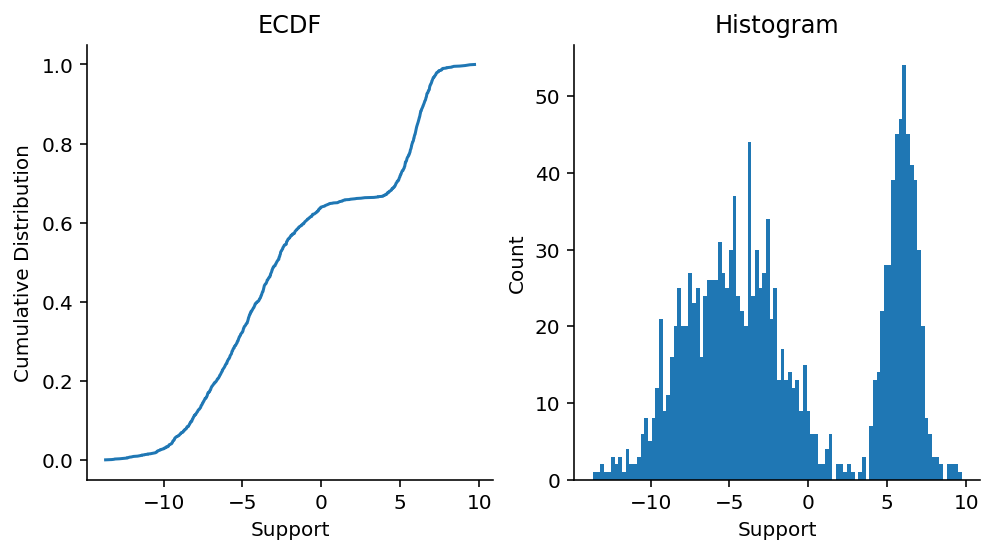

In [3]:
#| echo: false
#| label: fig-data
#| fig-cap: Empirical cumulative distribution function (ECDF) and histogram of a 2-component mixture Gaussian data.
#| code-fold: true

from jax import random 
import jax.numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as onp

def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data) + 1) / len(data)
    return x, y

key = random.PRNGKey(45)
k1, k2, k3 = random.split(key, 3)

mix1 = random.normal(k1, shape=(1000,)) * 3 - 5
mix2 = random.normal(k2, shape=(500,)) * 1 + 6
data = np.concatenate([mix1, mix2]).reshape(-1, 1)

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
plt.sca(axes[0])
plt.plot(*ecdf(data.flatten()))
plt.xlabel("Support")
plt.ylabel("Cumulative Distribution")
plt.title("ECDF")
sns.despine()

plt.sca(axes[1])
plt.hist(onp.array(data), bins=100)
plt.xlabel("Support")
plt.ylabel("Count")
plt.title("Histogram")
plt.show()

### Train a score function model

As with before, we will train an approximate score function 
on this mixture Gaussian data.
The model architecture will be a simple feed-forward neural network.

In [4]:
from score_models.training import fit
from score_models.models import FeedForwardModel1D
from score_models.losses import score_matching_loss
import optax

ffmodel = FeedForwardModel1D()

optimizer = optax.adam(learning_rate=5e-3)
updated_model, loss_history = fit(
    ffmodel, 
    data, 
    score_matching_loss, 
    optimizer, 
    steps=2_000, 
    progress_bar=False
)


Let us now diagnose whether we converged.

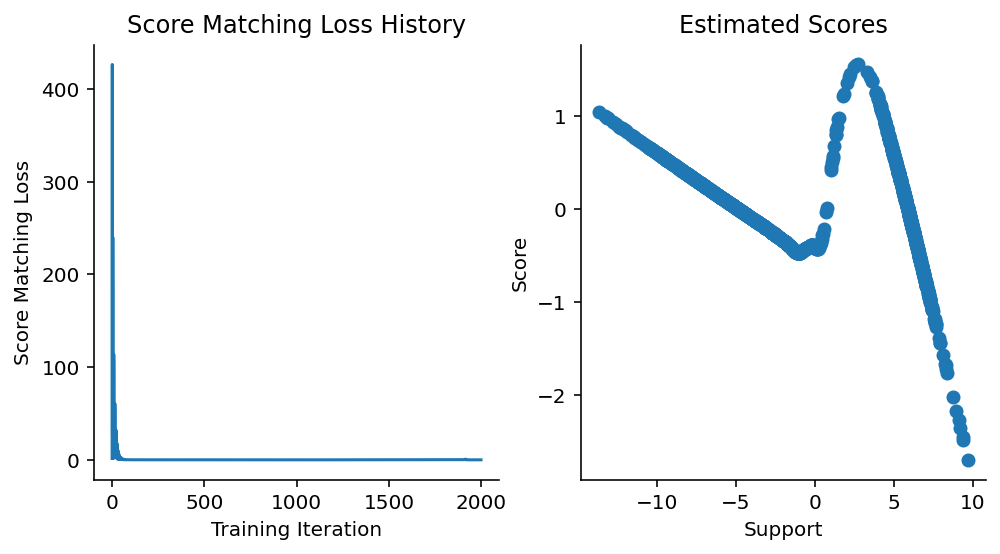

In [5]:
#| label: fig-gaussian-model-loss-history
#| fig-cap: "Loss curve for Gaussian score model."
#| code-fold: true
from jax import vmap
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)


plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Score Matching Loss")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(data)
plt.scatter(data.squeeze(), updated_model_scores.squeeze())
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Estimated Scores")
sns.despine()

From what we know about how the score function of a 2-component mixture should look like,
It is safe to say that we have converged and can use the trained model.
One thing should be noted here:
we have explicitly avoided doing train/val/test splits here, but doing so is recommended!
Just as with any other loss function for predicting classes or real numbers,
we would use splitting here to determine when to stop training.

### Sample using the score function

We are now going to attempt to use the neural network score approximator
in a Langevin dynamics MCMC sampler.
Langevin dynamics, being an iterative MCMC sampler,
needs the use of a for-loop with carryover construct.
I have taken advantage of `jax.lax.scan` for fast, compiled looping with carryover.
In addition to that, because the operation requires parameterization of a function,
Equinox is another natural choice for its implementation.

In [6]:
#| code-fold: true

from score_models.sampler import LangevinDynamicsChain
from inspect import getsource

print(getsource(LangevinDynamicsChain))


class LangevinDynamicsChain(eqx.Module):
    """Langevin dynamics chain."""

    gradient_func: eqx.Module
    n_samples: int = 1000
    epsilon: float = 5e-3

    @eqx.filter_jit
    def __call__(self, x, key: random.PRNGKey):
        """Callable implementation for sampling.

        :param x: Data of shape (batch, :).
        :param key: PRNGKey for random draws.
        :returns: A tuple of final draw and historical draws."""

        def langevin_step(prev_x, key):
            """Scannable langevin dynamics step.

            :param prev_x: Previous value of x in langevin dynamics step.
            :param key: PRNGKey for random draws.
            :returns: A tuple of new x and previous x.
            """
            draw = random.normal(key, shape=x.shape)
            new_x = (
                prev_x
                + self.epsilon * vmap(self.gradient_func)(prev_x)
                + np.sqrt(2 * self.epsilon) * draw
            )
            return new_x, prev_x

        keys = ran

### Sample one chain

Let's run one chain of the Langevin dynamics sampler
to see what the samples from one chain look like. 
For comparison, we will show what the sampler draws look like
when we have an untrained model vs. a trained model,
and so we will have two samplers instantiated as well.

In [7]:
trained_model_sampler = LangevinDynamicsChain(gradient_func=updated_model, epsilon=5e-1)
key = random.PRNGKey(55)
final, trained_samples = trained_model_sampler(np.array([[2.0]]), key)

untrained_model_sampler = LangevinDynamicsChain(gradient_func=ffmodel, epsilon=5e-1)
final, untrained_samples = untrained_model_sampler(np.array([[2.0]]), key)


Now that the Langevin dynamics samplers have been instantiated and run for one chain,
let's see what our "draws" look like.

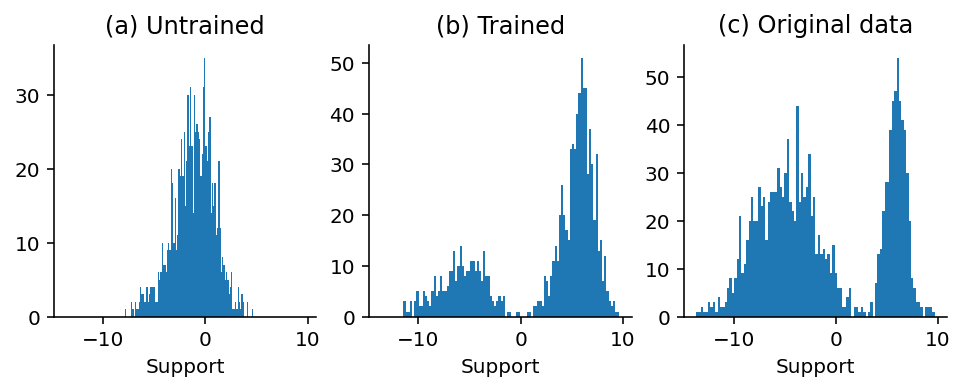

In [8]:
#| code-fold: true
#| label: fig-langevin-dynamics-trained-vs-untrained
#| fig-cap: Draws from Langevin dynamics sampler. Samples from a sampler with an (a) untrained neural network score function and (b) trained neural network compared to (c) original sampled data.
fig, axes = plt.subplots(figsize=(8, 2.5), ncols=3, sharex=True)

plt.sca(axes[0])
plt.hist(onp.array(untrained_samples), bins=100)
plt.title("(a) Untrained")
plt.xlabel("Support")

plt.sca(axes[1])
plt.hist(onp.array(trained_samples), bins=100)
plt.title("(b) Trained")
plt.xlabel("Support")

plt.sca(axes[2])
plt.hist(onp.array(data), bins=100)
plt.title("(c) Original data")
plt.xlabel("Support")

sns.despine()

That looks amazing!
It looks abundantly clear to me that with one chain, 
we can draw new samples from our mixture distribution
_without needing to know the mixture distribution parameters_!
There isn't perfect correspondence,
but for the purposes of drawing new samples _that look like existing ones_,
an approximate model appears to be good enough.

### Multi-Chain Sampling

We are now going to attempt multi-chain sampling!
Let us instantiate 1,000 starter points 
drawn randomly from a Gaussian
and then run the sampler for 200 steps.
Note here that by designing our single chain sampler 
to be called on a single starter point (of the right shape)
and a pseudorandom number generator key,
we can `vmap` the sampling routine 
over multiple starter points and keys rather trivially.


In [9]:
key = random.PRNGKey(49)
n_particles = 10_000
starter_points = random.normal(key, shape=(n_particles, 1, 1)) * 5

starter_keys = random.split(key, n_particles)

trained_model_sampler = LangevinDynamicsChain(
    gradient_func=updated_model, n_samples=100, epsilon=5e-1
)
final, trained_samples = vmap(trained_model_sampler)(starter_points, starter_keys)


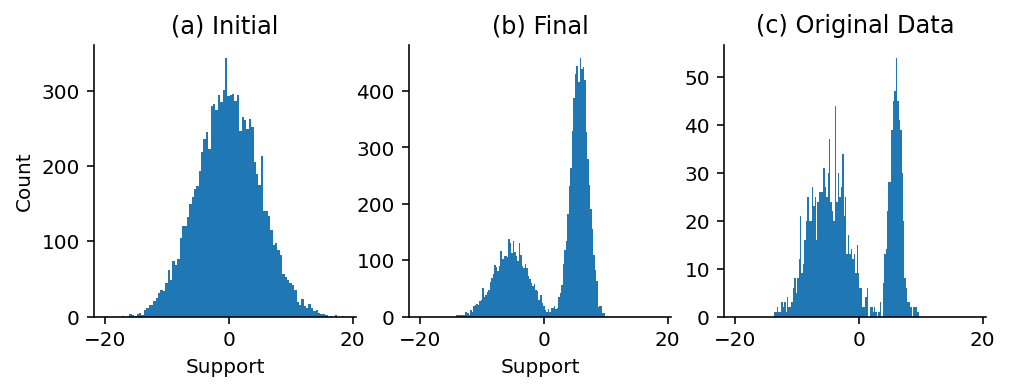

In [10]:
#| code-fold: true 
#| fig-cap: (a) Initial and (b) final positions of points alongside (c) the original data.
#| label: fig-langevin-dynamics-sampler-before-after
fig, axes = plt.subplots(figsize=(8, 2.5), nrows=1, ncols=3, sharex=True)

plt.sca(axes[0])
plt.xlabel("Support")
plt.title("(a) Initial")
plt.ylabel("Count")
plt.hist(onp.array(starter_points.flatten()), bins=100)

plt.sca(axes[1])
plt.xlabel("Support")
plt.title("(b) Final")
plt.hist(onp.array(final.flatten()), bins=100)

plt.sca(axes[2])
plt.hist(onp.array(data), bins=100)
plt.title("(c) Original Data")

sns.despine()

@fig-langevin-dynamics-sampler-before-after looks quite reasonable! 
Our original draws from a relatively wide Gaussian
get split up into both component distribution which is encouraging here.
This is encouraging!

One thing I hope is evident here 
is the `vmap`-ing of the the sampler over multiple starting points.
For me, that is one of the elegant things about JAX.
With `vmap`, `lax.scan`, and other primitives in place,
as long as we can "stage out" the elementary units of computation
by implementing them as callables (or functions),
we have a very clear path to incorporating them in loopy constructs
such as `vmap` and `lax.scan`, and JIT-compiling them using `jit`.